<a href="https://colab.research.google.com/github/alfredoh90/Capstone3/blob/main/validation_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
seed = 180

In [2]:
# Importing Keras
from keras.models import Sequential                          # Neural network model as a sequence of layers.
from keras.layers import Conv2D                              # Convolutional layer
from keras.layers import MaxPooling2D                        # Max pooling layer
from keras.layers import Flatten                             # Layer used to flatten 2D arrays for fully-connected layers.
from keras.layers import Dense                               # This layer adds fully-connected layers to the neural network.
from keras.layers import Dropout                             # This serves to prevent overfitting by dropping out a random set of activations.
from keras.layers import BatchNormalization                  # This is used to normalize the activations of the neurons.
from keras.layers import Activation                          # Layer for activation functions
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit
from keras.models import load_model                          # This helps us to load trained models
# Preprocessing layers
from keras.layers import Rescaling                           # This layer rescales pixel values

# Importing TensorFlow
import tensorflow as tf

Next, we need to create a pipeline for the validation data to be used in this part of the process:

In [51]:
# Creating a Dataset for the Training data
test = tf.keras.utils.image_dataset_from_directory(
    "drive/MyDrive/Capstone3/data/test",  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = ['pos', 'neg'], #extensions of the folders holding the classes
    batch_size = 16,    # Number of processed samples before updating the model's weights
    image_size = (400, 400), # Defining a fixed dimension for all images
    shuffle = False,  # Not Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True # Resize images without aspect ratio distortion
)

Found 3629 files belonging to 2 classes.


In [52]:
#Create a list of the file paths to be able to review later on
file_paths = test.file_paths

Just like with validation, we will rescale the images and load the model as saved in our previous step. to confirm lets review the model arquitecture:

In [53]:
scaler = Rescaling(1./255) # Defining scaler values between 0 to 1
test = test.map(lambda x, y: (scaler(x), y)) # Rescaling datasets

In [7]:
# Checking minimum and maximum pixel values in the training dataset
min_value = float('inf')
max_value = -float('inf')

for img, label in test:
    batch_min = tf.reduce_min(img)
    batch_max = tf.reduce_max(img)

    min_value = min(min_value, batch_min.numpy())
    max_value = max(max_value, batch_max.numpy())

print('\nMinimum pixel value in the Validation dataset', min_value)
print('\nMaximum pixel value in the Validation dataset', max_value)


Minimum pixel value in the Validation dataset 0.0

Maximum pixel value in the Validation dataset 1.0


In [6]:
model = tf.keras.models.load_model('drive/MyDrive/Capstone3/safety_gear_detect_V4.keras')

Next, we will calculate the predictions from the model using .predict and calculate the loss and accuracy from the test images:

In [54]:
preds = model.predict(test)  # Running model on the test dataset
val_loss, val_acc = model.evaluate(test) # Obtaining Loss and Accuracy on the val dataset

print('\nValidation Loss: ', val_loss)
print('\nValidation Accuracy: ', np.round(val_acc * 100), '%')

227/227 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step
227/227 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9508 - loss: 0.1691

Validation Loss:  0.3588975965976715

Validation Accuracy:  90.0 %


Once the predictions have been recorded. Lets review the results to understand the architechture:

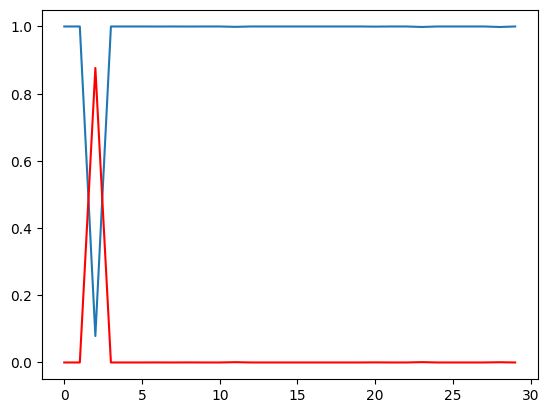

In [55]:
plt.plot(preds[:30,0])
plt.plot(preds[:30,1], color='r')

It looks like the predictions are values for each image with the probability of the image belonging to either the category 0 or 1 (pos or neg in this case).
Since we have these results, lets build a DF with the file names as well as the probabilities for pos or neg:

In [56]:
#create DF results
df_results = pd.DataFrame({'name':file_paths, 'pos':preds[:,0], 'neg':preds[:,1]})

In [57]:
df_results.describe()

pos           neg
count  3.629000e+03  3.629000e+03
mean   5.324990e-01  4.554888e-01
std    4.534273e-01  4.504374e-01
min    2.139964e-20  0.000000e+00
25%    2.938378e-02  4.557317e-17
50%    5.559557e-01  3.482910e-01
75%    1.000000e+00  9.660511e-01
max    1.000000e+00  1.000000e+00

In [58]:
df_results.head()

name       pos           neg
0  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  4.297095e-30
1  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  3.834341e-16
2  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  0.078714  8.765453e-01
3  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  0.000000e+00
4  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  0.000000e+00

With these results, we will create a pred_image function to visualize an image as well as run the prediction using the model. This way we can visualize the image and the results at the same time:

In [16]:
from PIL import Image
def pred_image(im_name):
    # Loading the image
    image_path = 'drive/MyDrive/Capstone3/data/test/' + im_name
    original_image = Image.open(image_path)
    print('Picture of safety gear: \n')
    plt.imshow(original_image)

    # Manually preprocessing image as we did when training
    preprocessed_image = original_image.resize((400, 400))
    preprocessed_image = np.array(preprocessed_image) / 255.0

    #predict the class using the image
    predic = model.predict(np.expand_dims(preprocessed_image, axis = 0))
    labels = ['pos', 'neg']

    preds_class = np.argmax(predic)
    preds_label = labels[preds_class]

    print(f'\nPredicted Class: {preds_label}')
    print(f'\nConfidence Score: {predic[0][preds_class]}')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Predicted Class: neg

Confidence Score: 0.9881007671356201


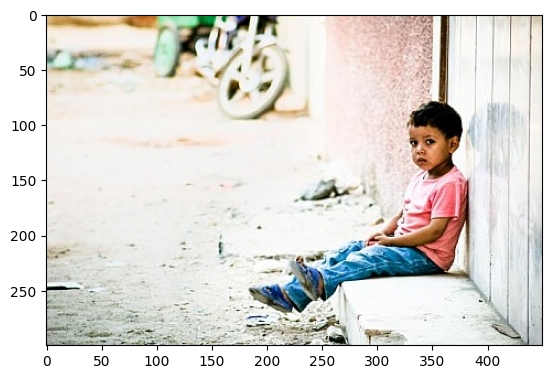

In [60]:
#testing for a random positive image
pred_image('neg/image_782.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Predicted Class: pos

Confidence Score: 0.9955052137374878


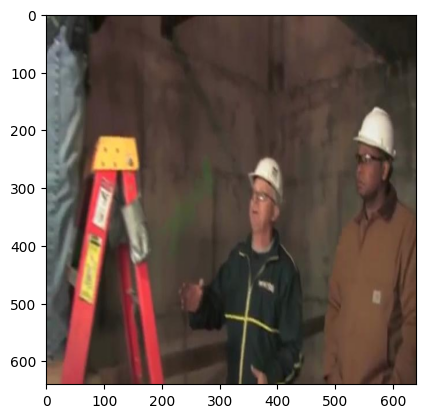

In [61]:
#testing for a random positive image
pred_image('pos/helmet_jacket_07378.jpg')

In [62]:
df_results['pred'] = 'pos' #create pred column as positive by default
df_results.loc[df_results.pos<df_results.neg, 'pred']='neg' #if the prob of negative is higher than prob of positive, assign negative
df_results.head() #confirm results

name       pos           neg  \
0  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  4.297095e-30   
1  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  3.834341e-16   
2  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  0.078714  8.765453e-01   
3  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  0.000000e+00   
4  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  0.000000e+00   

  pred  
0  pos  
1  pos  
2  neg  
3  pos  
4  pos

In [63]:
df_results['label'] = 'neg' #create a label column as neg by default
df_results.loc[df_results.name.str.contains('pos'), 'label'] = 'pos' #label as positive only if identified as such
df_results.head()

name       pos           neg  \
0  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  4.297095e-30   
1  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  3.834341e-16   
2  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  0.078714  8.765453e-01   
3  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  0.000000e+00   
4  drive/MyDrive/Capstone3/data/test/pos/helmet_j...  1.000000  0.000000e+00   

  pred label  
0  pos   pos  
1  pos   pos  
2  neg   pos  
3  pos   pos  
4  pos   pos

In [64]:
df_results.name = df_results.name.str.split("/", expand = True).iloc[:,-1] #separate the name from the path and save as the name

In [65]:
df_results.head()

name       pos           neg pred label
0  helmet_jacket_07350.jpg  1.000000  4.297095e-30  pos   pos
1  helmet_jacket_07351.jpg  1.000000  3.834341e-16  pos   pos
2  helmet_jacket_07352.jpg  0.078714  8.765453e-01  neg   pos
3  helmet_jacket_07353.jpg  1.000000  0.000000e+00  pos   pos
4  helmet_jacket_07354.jpg  1.000000  0.000000e+00  pos   pos

In [66]:
false_pos = df_results[(df_results.pred != df_results.label) & (df_results.pred == 'pos')] #false positives labeled negative and categorized positive

In [67]:
1-(len(false_pos)/len(df_results)) #calculate the accuracy

0.9087903003582254

In [68]:
false_pos.sort_values('pos', ascending = False)

name       pos           neg pred label
3213   image_574.jpg  1.000000  6.064309e-17  pos   neg
2230  image_1731.jpg  1.000000  2.225251e-11  pos   neg
2949   image_308.jpg  1.000000  2.360629e-09  pos   neg
1594   image_102.jpg  1.000000  5.191337e-08  pos   neg
3018   image_377.jpg  1.000000  1.632420e-10  pos   neg
...              ...       ...           ...  ...   ...
3555   image_920.jpg  0.440148  3.406822e-01  pos   neg
1784  image_1236.jpg  0.437263  4.163822e-01  pos   neg
2791  image_2381.jpg  0.435720  4.095195e-01  pos   neg
1875  image_1342.jpg  0.429158  4.108500e-01  pos   neg
2325  image_1842.jpg  0.426852  4.193885e-01  pos   neg

[331 rows x 5 columns]

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Predicted Class: pos

Confidence Score: 1.0


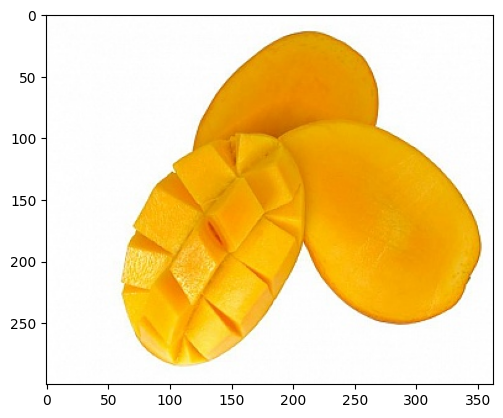

In [69]:
pred_image('neg/image_574.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Predicted Class: pos

Confidence Score: 1.0


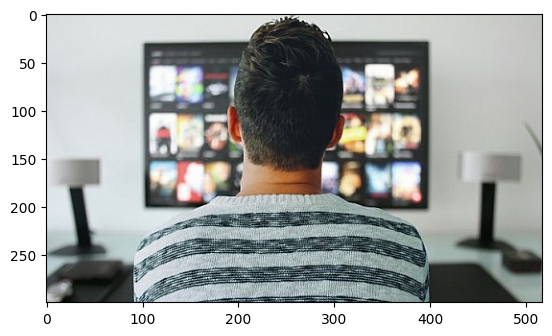

In [70]:
pred_image('neg/image_1731.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Predicted Class: pos

Confidence Score: 1.0


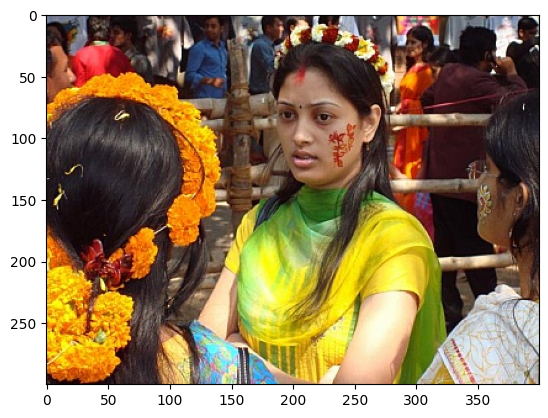

In [71]:
pred_image('neg/image_308.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Predicted Class: pos

Confidence Score: 1.0


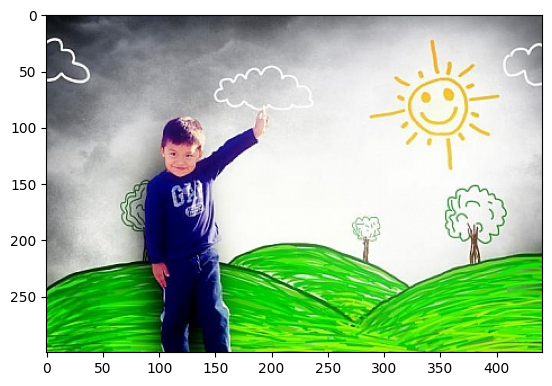

In [72]:
pred_image('neg/image_102.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Predicted Class: pos

Confidence Score: 1.0


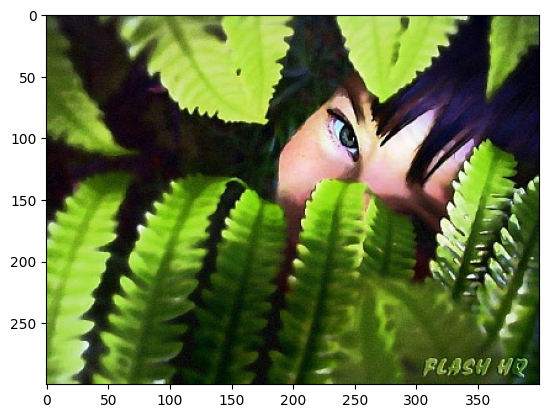

In [74]:
pred_image('neg/image_377.jpg')

After checking the top 5, lets review the bottom 2:

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Predicted Class: pos

Confidence Score: 0.9910897016525269


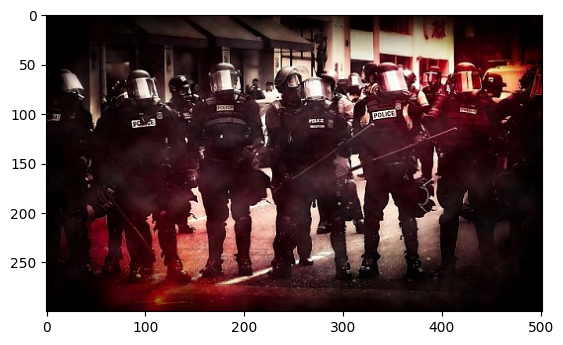

In [75]:
pred_image('neg/image_1842.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Predicted Class: pos

Confidence Score: 1.0


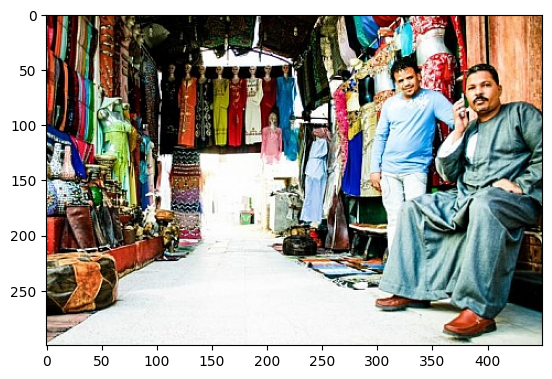

In [76]:
pred_image('neg/image_1342.jpg')

it looks like the recurring factor with all these 'Negative' images incorrectly labeled positive is the presence of bright colours possibly skweing the model to think there is a presence of safety gear.
One of the images is showing a type of safety gear but was originally labelled negative. This could show the model understands the concept of safety gear and is correcting our mistake of mislabeling this image.

Lets now take a look at the false negatives:

In [77]:
false_neg = df_results[(df_results.pred != df_results.label) & (df_results.pred == 'neg')] #false negative labeled positive and categorized negative

In [78]:
1-(len(false_neg)/len(df_results)) #calculate the accuracy

0.9914577018462386

In [79]:
false_neg.sort_values('neg', ascending = False)

name       pos       neg pred label
479   helmet_jacket_07829.jpg  0.001345  0.997826  neg   pos
1331  helmet_jacket_08681.jpg  0.001801  0.997717  neg   pos
1203  helmet_jacket_08553.jpg  0.001736  0.997606  neg   pos
416   helmet_jacket_07766.jpg  0.007677  0.995148  neg   pos
834   helmet_jacket_08184.jpg  0.030546  0.979290  neg   pos
556   helmet_jacket_07906.jpg  0.028431  0.975336  neg   pos
410   helmet_jacket_07760.jpg  0.020921  0.973770  neg   pos
309   helmet_jacket_07659.jpg  0.040275  0.969207  neg   pos
1012  helmet_jacket_08362.jpg  0.028706  0.968988  neg   pos
647   helmet_jacket_07997.jpg  0.024077  0.956809  neg   pos
1114  helmet_jacket_08464.jpg  0.046725  0.956480  neg   pos
599   helmet_jacket_07949.jpg  0.046966  0.941865  neg   pos
592   helmet_jacket_07942.jpg  0.082178  0.932778  neg   pos
1478  helmet_jacket_08828.jpg  0.064014  0.929495  neg   pos
1257  helmet_jacket_08607.jpg  0.090138  0.905860  neg   pos
2     helmet_jacket_07352.jpg  0.078714  0.876545  neg   pos
343   helmet_jacket_07693.jpg  0.144875  0.802764  neg   pos
1491  helmet_jacket_08841.jpg  0.250682  0.755704  neg   pos
499   helmet_jacket_07849.jpg  0.199216  0.750294  neg   pos
730   helmet_jacket_08080.jpg  0.154332  0.727274  neg   pos
413   helmet_jacket_07763.jpg  0.182829  0.714775  neg   pos
1098  helmet_jacket_08448.jpg  0.233101  0.702788  neg   pos
415   helmet_jacket_07765.jpg  0.273924  0.668200  neg   pos
1364  helmet_jacket_08714.jpg  0.245869  0.650117  neg   pos
1152  helmet_jacket_08502.jpg  0.297743  0.612968  neg   pos
1304  helmet_jacket_08654.jpg  0.401247  0.570294  neg   pos
389   helmet_jacket_07739.jpg  0.334423  0.555306  neg   pos
893   helmet_jacket_08243.jpg  0.359842  0.537266  neg   pos
693   helmet_jacket_08043.jpg  0.367089  0.518480  neg   pos
312   helmet_jacket_07662.jpg  0.239149  0.516580  neg   pos
63    helmet_jacket_07413.jpg  0.370471  0.507616  neg   pos

One of the first things to notice is definetly how little this resulting set is (with an accuracy of over 99%). Lets start by looking at the top 5 as well as the bottom 2 to try to identify any patterns:

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Predicted Class: neg

Confidence Score: 0.9998883008956909


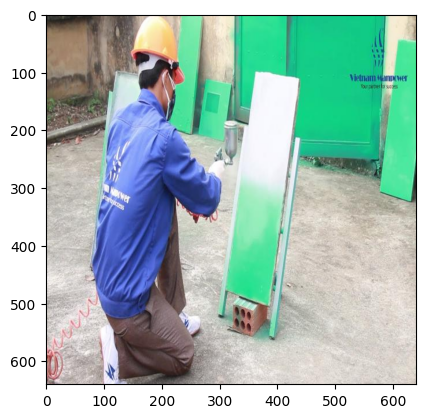

In [81]:
pred_image('pos/helmet_jacket_07829.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Predicted Class: neg

Confidence Score: 0.9971869587898254


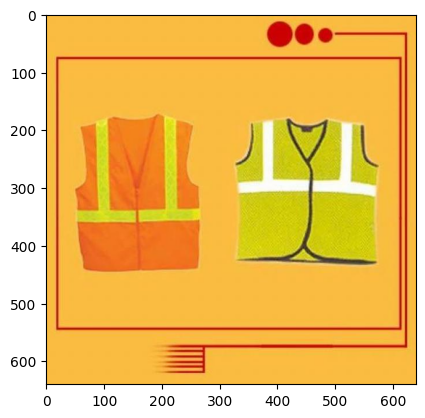

In [83]:
pred_image('pos/helmet_jacket_08681.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Predicted Class: neg

Confidence Score: 0.9968106150627136


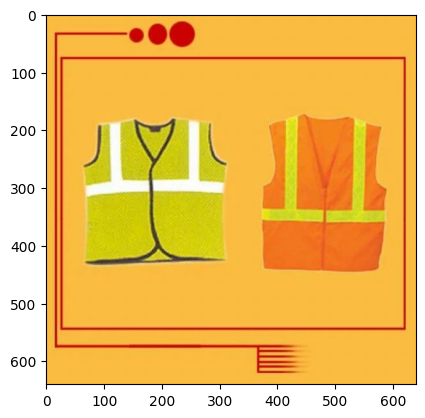

In [84]:
pred_image('pos/helmet_jacket_08553.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Predicted Class: neg

Confidence Score: 0.9960891008377075


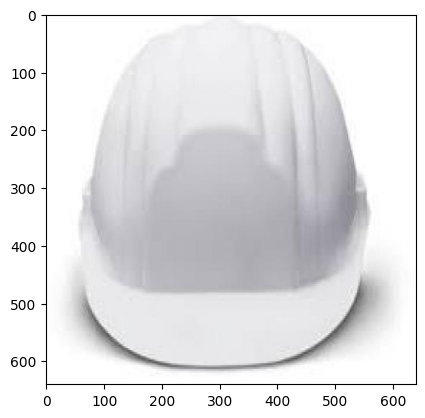

In [85]:
pred_image('pos/helmet_jacket_07766.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Predicted Class: neg

Confidence Score: 0.9985765218734741


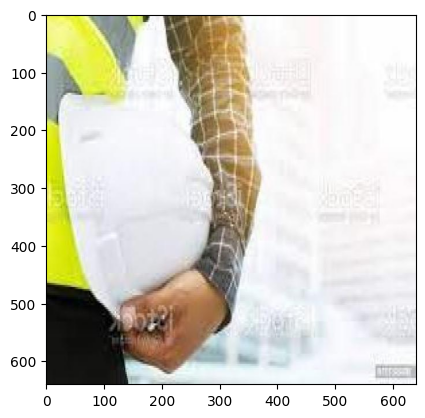

In [87]:
pred_image('pos/helmet_jacket_08184.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Predicted Class: neg

Confidence Score: 0.705091655254364


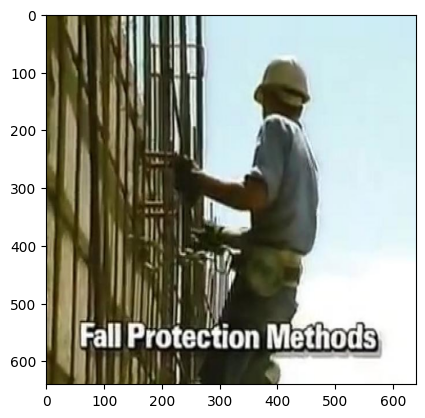

In [89]:
pred_image('pos/helmet_jacket_07662.jpg')

Picture of safety gear: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Predicted Class: neg

Confidence Score: 0.6191746592521667


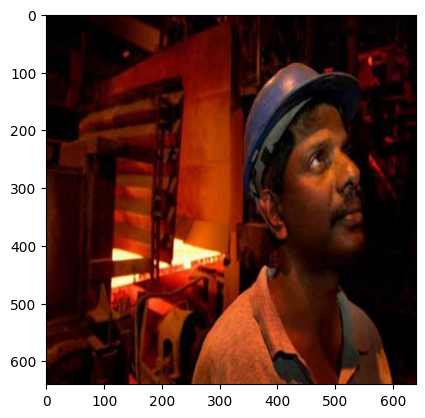

In [90]:
pred_image('pos/helmet_jacket_07413.jpg')

From what we can see, it looks like the majority of the images labeled positive but predicted negative were predicted negative because the safety gear was present but the person was not (either just the helmet or just the vest or both helmet and vest but always no person). In the bottom 2 cases, we see both the person has only the helmet and not the vest which could explain why the model doesnt consider this images 'Positive'